## Table des Matières

1. [Introduction](#introduction)
2. [Étape 1 : Importer les Bibliothèques Nécessaires](#étape-1--importer-les-bibliothèques-nécessaires)
3. [Étape 2 : Définir les Fonctions de Prétraitement et d’Augmentation](#étape-3--définir-la-fonction-de-création-des-modèles)
4. [Étape 3 : Définir la Fonction de Création des Modèles](#étape-3--définir-la-fonction-de-création-des-modèles)
5. [Étape 4 : Définir la Fonction de Téléchargement Audio depuis YouTube](#etape-4--definir-la-fonction-de-telechargement-audio-depuis-youtube)
6. [Étape 5 : Initialiser les Hyperparamètres](#etape-5--initialiser-les-hyperparametres)
7. [Étape 6 : Charger et Prétraiter les Données](#etape-6--charger-et-pretraiter-les-donnees)
8. [Étape 7 : Itérer sur les Combinaisons d'Hyperparamètres et Entraîner les Modèles](#etape-7--iterer-sur-les-combinaisons-dhyperparametres-et-entrainer-les-modeles)
9. [Étape 8 : Analyser et Sauvegarder les Résultats](#etape-8--analyser-et-sauvegarder-les-resultats)
10. [Étape 9 : Visualiser les Meilleurs Résultats](#etape-9--visualiser-les-meilleurs-resultats)
11. [Étape 10 : Sauvegarder et Charger les Meilleurs Modèles](#etape-10--sauvegarder-et-charger-les-meilleurs-modeles)
12. [Étape 11 : Prédiction sur de Nouveaux Échantillons](#etape-11--prediction-sur-de-nouveaux-echantillons)

## Introduction

Dans ce notebook, nous allons :

1. **Charger et prétraiter les données audio** en extrayant les caractéristiques MFCC avec augmentation de données.
2. **Définir et entraîner différents modèles** (CNN 2D, CNN profond, RNN avec LSTM/GRU) en testant diverses combinaisons d'hyperparamètres tels que la taille du batch, le nombre d'époques, le taux d'apprentissage et le nombre de coefficients MFCC.
3. **Évaluer les performances** de chaque modèle et collecter les métriques dans un tableau pour une analyse comparative.
4. **Visualiser les meilleurs résultats** et **sauvegarder les modèles** optimaux pour une utilisation future.

## Étape 1 : Importer les Bibliothèques Nécessaires

Tout d’abord, importons toutes les bibliothèques nécessaires pour le prétraitement des données, la création des modèles, et l’évaluation des performances.

In [27]:
import os
import numpy as np
import pandas as pd
import librosa
import joblib
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, LSTM, GRU, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import yt_dlp as youtube_dl

# Pour afficher les graphiques directement dans le notebook
%matplotlib inline

## Étape 2 : Définir les Fonctions de Prétraitement et d’Augmentation

Nous allons définir les fonctions nécessaires pour :

- **Augmenter les données audio** (ajout de bruit, modification de la hauteur et de la vitesse).
- **Padder ou tronquer les MFCCs** pour assurer une longueur fixe.
- **Extraire les MFCCs** avec augmentation.

In [28]:
def augment_audio(audio, sr):
    """
    Applique des augmentations sur l'audio : ajout de bruit, modification de la hauteur et de la vitesse.
    """
    # Ajout de bruit
    noise = np.random.randn(len(audio)) * 0.005
    audio_with_noise = audio + noise

    # Modifier la hauteur en fréquence
    try:
        pitch_factor = np.random.uniform(-5, 5)  # En demi-tons
        audio_pitch_shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=pitch_factor)
    except:
        audio_pitch_shifted = audio

    # Modifier la vitesse
    try:
        audio_stretched = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))
    except:
        audio_stretched = audio

    return [audio_with_noise, audio_pitch_shifted, audio_stretched]

def pad_or_truncate_mfcc(mfccs, fixed_length):
    """
    Ajuste la longueur des MFCCs (n_mfcc, T) à (n_mfcc, fixed_length)
    - Tronque si T > fixed_length
    - Ajoute du padding (zéros) si T < fixed_length
    """
    length = mfccs.shape[1]
    if length > fixed_length:
        mfccs = mfccs[:, :fixed_length]
    elif length < fixed_length:
        pad_width = fixed_length - length
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    return mfccs

def extract_features_with_augmentation(file_path, fixed_length, n_mfcc=40):
    """
    Extrait les MFCCs d'un fichier audio avec augmentation de données.
    """
    try:
        audio, sr = librosa.load(file_path, duration=30)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfccs = pad_or_truncate_mfcc(mfccs, fixed_length)

        # Augmentations
        augmented_audios = augment_audio(audio, sr)
        augmented_mfccs = []
        for a in augmented_audios:
            m = librosa.feature.mfcc(y=a, sr=sr, n_mfcc=n_mfcc)
            m = pad_or_truncate_mfcc(m, fixed_length)
            augmented_mfccs.append(m)

        # On renvoie la liste (original + augmentations) directement sous forme (n_mfcc, T)
        all_mfccs = [mfccs] + augmented_mfccs
        return all_mfccs
    except Exception as e:
        print(f"Erreur lors du traitement du fichier {file_path}: {e}")
        return []

## Étape 3 : Définir la Fonction de Création des Modèles

Nous allons définir une fonction qui crée différents types de modèles en fonction des hyperparamètres spécifiés.

In [29]:
def create_model(model_type, input_shape, num_classes, learning_rate=0.001):
    """
    Crée un modèle de deep learning en fonction du type spécifié.
    """
    model = Sequential()
    
    if model_type == 'CNN_2D_basic':
        # Modèle CNN 2D de base avec padding 'same'
        model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(num_classes, activation='softmax'))
    
    elif model_type == 'CNN_2D_deep':
        # Modèle CNN 2D plus profond avec padding 'same'
        model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(num_classes, activation='softmax'))
    
    elif model_type == 'CRNN':
        # Modèle Convolutional Recurrent Neural Network avec padding 'same'
        model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.3))

        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(128, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(64))
        model.add(Dropout(0.3))
        model.add(Dense(num_classes, activation='softmax'))
    
    elif model_type == 'CNN_1D':
        # Modèle CNN 1D avec padding 'same'
        model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(num_classes, activation='softmax'))
    
    elif model_type == 'RNN_LSTM':
        # Modèle avec couches LSTM
        # Reshape pour LSTM : (N, T, n_mfcc)
        model.add(Flatten(input_shape=input_shape))  # Convertir en séquence pour LSTM
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.3))
        model.add(LSTM(128, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(64))
        model.add(Dropout(0.3))
        model.add(Dense(num_classes, activation='softmax'))
    
    elif model_type == 'RNN_GRU':
        # Modèle avec couches GRU
        # Reshape pour GRU : (N, T, n_mfcc)
        model.add(Flatten(input_shape=input_shape))  # Convertir en séquence pour GRU
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.3))
        model.add(GRU(128, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(GRU(64))
        model.add(Dropout(0.3))
        model.add(Dense(num_classes, activation='softmax'))
    
    else:
        raise ValueError(f"Type de modèle inconnu: {model_type}")

    # Compilation du modèle
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


## Étape 4 : Définir la Fonction de Téléchargement Audio depuis YouTube

Cette fonction permet de télécharger un fichier audio depuis une URL YouTube pour tester les prédictions.

In [30]:
def download_youtube_audio(youtube_url, output_path="downloaded_audio.wav"):
    """
    Télécharge l'audio d'une vidéo YouTube et le sauvegarde en fichier WAV.
    """
    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': 'temp_audio.%(ext)s',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
    }

    # Télécharger l'audio
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([youtube_url])

    # Renommer le fichier pour l'utiliser
    if os.path.exists("temp_audio.wav"):
        os.rename("temp_audio.wav", output_path)
        print(f"Audio téléchargé et sauvegardé sous : {output_path}")
    else:
        print("Erreur lors du téléchargement.")


## Étape 5 : Initialiser les Hyperparamètres

Définissons les différentes valeurs des hyperparamètres que nous allons tester.

In [31]:
# Définition des hyperparamètres à tester
batch_sizes = [16, 32, 64]
epochs_list = [20, 50, 100]
learning_rates = [0.001, 0.0001, 0.00001]
model_types = ['CNN_2D_basic', 'CNN_2D_deep', 'CRNN', 'RNN_LSTM', 'RNN_GRU']  # Ajouter d'autres modèles si nécessaire
n_mfcc_values = [20, 40, 60]  # "token size" interprété comme nombre de MFCCs

# Préparation du tableau de résultats
results = []

# Créer un répertoire pour sauvegarder les modèles
os.makedirs('models', exist_ok=True)


## Étape 6 : Charger et Prétraiter les Données

Pour chaque valeur de `n_mfcc`, nous chargerons et prétraiterons les données audio avec augmentation.

In [32]:
def load_audio_features_with_augmentation(data_path, fixed_length, n_mfcc=40):
    """
    Charge les features audio avec augmentation et ajuste les MFCCs à une longueur fixe.
    """
    genres = os.listdir(data_path)
    X_list = []
    y_list = []

    for genre in genres:
        genre_path = os.path.join(data_path, genre)
        for file_name in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file_name)
            mfccs_list = extract_features_with_augmentation(file_path, fixed_length=fixed_length, n_mfcc=n_mfcc)
            for m in mfccs_list:
                # m est de forme (n_mfcc, fixed_length)
                X_list.append(m)
                y_list.append(genre)

    X = np.array(X_list)  # X: (N, n_mfcc, fixed_length)
    y = np.array(y_list)

    # Ajout de la dimension "canal" pour le CNN 2D : (N, n_mfcc, fixed_length, 1)
    X = X[..., np.newaxis]
    return X, y


## Étape 7 : Itérer sur les Combinaisons d'Hyperparamètres et Entraîner les Modèles

Nous allons maintenant itérer sur toutes les combinaisons possibles d'hyperparamètres et de types de modèles, entraîner chaque modèle, évaluer ses performances, et enregistrer les résultats.

In [33]:
def model_exists(n_mfcc, model_type, batch_size, epochs, lr):
    """
    Vérifie si le modèle avec les hyperparamètres spécifiés existe déjà.
    """
    model_save_path = f"models/n_mfcc_{n_mfcc}/{model_type}_bs{batch_size}_ep{epochs}_lr{lr}.keras"
    return os.path.exists(model_save_path)

In [34]:
# Chemin vers les données audio
data_path = "Data/genres_original"

# Définir fixed_length en fonction de n_mfcc et des paramètres de vos MFCC
fixed_length = 1293  # À ajuster selon votre dataset (en fonction du sr et hop_length)

# Itération sur les différentes valeurs de n_mfcc (token size)
for n_mfcc in n_mfcc_values:
    print(f"\nTraitement pour n_mfcc = {n_mfcc}")
    
    # Charger les données avec augmentation
    X, y = load_audio_features_with_augmentation(data_path, fixed_length, n_mfcc=n_mfcc)

    print(f"Shape des données: X={X.shape}, y={y.shape}")
    
    # Encodage des labels
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded, num_classes=len(encoder.classes_))

    # Sauvegarder l'encodeur (écrasez le précédent si nécessaire)
    joblib.dump(encoder, 'label_encoder.joblib')

    # Split des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

    # Normalisation des données
    # Par exemple, vous pouvez normaliser les MFCCs entre 0 et 1
    X_train = X_train / np.max(X_train)
    X_test = X_test / np.max(X_test)

    # Itération sur les différentes combinaisons d'hyperparamètres
    for model_type, batch_size, epochs, lr in itertools.product(model_types, batch_sizes, epochs_list, learning_rates):
        print(f"Entraînement du modèle: {model_type}, Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {lr}")
        
        # Définir le chemin de sauvegarde du modèle
        model_save_path = f"models/n_mfcc_{n_mfcc}/{model_type}_bs{batch_size}_ep{epochs}_lr{lr}.keras"
        
        # Vérifier si le modèle existe déjà
        if model_exists(n_mfcc, model_type, batch_size, epochs, lr):
            print(f"Le modèle {model_type} avec bs={batch_size}, ep={epochs}, lr={lr} existe déjà. Passage au suivant.")
            continue  # Passer à la prochaine combinaison
        
        # Créer le répertoire si nécessaire
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
        
        # Définir le callback EarlyStopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Définir un ModelCheckpoint pour sauvegarder le meilleur modèle
        checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, verbose=1)
        
        # Définir le modèle
        input_shape = X_train.shape[1:]  # (n_mfcc, fixed_length, 1)
        num_classes = len(encoder.classes_)
        model = create_model(model_type, input_shape, num_classes, learning_rate=lr)

        # Entraîner le modèle
        history = model.fit(
            X_train, y_train, 
            validation_split=0.2, 
            epochs=epochs, 
            batch_size=batch_size, 
            callbacks=[early_stopping, checkpoint], 
            verbose=1  # Vous pouvez changer en 0 pour moins de sorties
        )

        # Évaluer le modèle
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        val_loss = min(history.history['val_loss'])
        val_accuracy = max(history.history['val_accuracy'])

        # Prédictions pour les métriques supplémentaires
        y_pred = np.argmax(model.predict(X_test), axis=-1)
        y_true = np.argmax(y_test, axis=-1)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        # Enregistrer les résultats
        result = {
            'n_mfcc': n_mfcc,
            'model_type': model_type,
            'batch_size': batch_size,
            'epochs': epochs,
            'learning_rate': lr,
            'accuracy': accuracy,
            'loss': loss,
            'validation_accuracy': val_accuracy,
            'validation_loss': val_loss,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        results.append(result)
        print(f"Résultat: {result}")

        # Sauvegarder les résultats après chaque entraînement pour éviter les pertes en cas d'interruption
        results_df = pd.DataFrame(results)
        results_df.to_csv('model_results.csv', index=False)
        print("Résultats sauvegardés dans 'model_results.csv'.")


Traitement pour n_mfcc = 20


/var/folders/g9/jzqz957j1slb_dkhyp9fl5_w0000gn/T/ipykernel_35556/1932264053.py:43: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, duration=30)
/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Erreur lors du traitement du fichier Data/genres_original/jazz/jazz.00054.wav: 
Shape des données: X=(3996, 20, 1293, 1), y=(3996,)
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 20, Learning Rate: 0.001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


2024-12-09 22:35:35.138633: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2367 - loss: 2.4252
Epoch 1: val_accuracy improved from -inf to 0.10938, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep20_lr0.001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.2371 - loss: 2.4235 - val_accuracy: 0.1094 - val_loss: 3.3632
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3681 - loss: 1.8434
Epoch 2: val_accuracy did not improve from 0.10938
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.3683 - loss: 1.8427 - val_accuracy: 0.1094 - val_loss: 4.4375
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4536 - loss: 1.5614
Epoch 3: val_accuracy did not improve from 0.10938
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.4537 - loss: 1.5613 - val_accuracy: 0.1094 - val_loss: 3.5908
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5240 - loss: 1.3066
Epoch 4: val_accuracy improved from 0.10938 to 0.26719, saving model to models/n_

2024-12-09 22:38:53.445975: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'accuracy': 0.7724999785423279, 'loss': 0.6713155508041382, 'validation_accuracy': 0.796875, 'validation_loss': 0.7112526297569275, 'precision': 0.8083635222276893, 'recall': 0.7725, 'f1_score': 0.7717869135559894}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 20, Learning Rate: 0.0001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1844 - loss: 2.4199
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep20_lr0.0001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.1848 - loss: 2.4185 - val_accuracy: 0.0812 - val_loss: 6.2490
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3411 - loss: 1.8784
Epoch 2: val_accuracy improved from 0.08125 to 0.09219, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep20_lr0.0001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.3412 - loss: 1.8781 - val_accuracy: 0.0922 - val_loss: 9.8178
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4297 - loss: 1.6416
Epoch 3: val_accuracy did not improve from 0.09219
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.4298 - loss: 1.6413 - val_accuracy: 0.0859 - val_loss: 12.9729
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5087 - loss:

2024-12-09 22:40:09.920183: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 16, 'epochs': 20, 'learning_rate': 0.0001, 'accuracy': 0.12125000357627869, 'loss': 6.095724105834961, 'validation_accuracy': 0.23906250298023224, 'validation_loss': 6.24904727935791, 'precision': 0.014701562500000001, 'recall': 0.12125, 'f1_score': 0.026223522853957636}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 20, Learning Rate: 1e-05


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.1329 - loss: 2.8908
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep20_lr1e-05.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.1331 - loss: 2.8899 - val_accuracy: 0.1000 - val_loss: 2.6655
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2034 - loss: 2.4486
Epoch 2: val_accuracy improved from 0.10000 to 0.11563, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep20_lr1e-05.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.2034 - loss: 2.4485 - val_accuracy: 0.1156 - val_loss: 3.5124
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2382 - loss: 2.3347
Epoch 3: val_accuracy did not improve from 0.11563
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.2382 - loss: 2.3345 - val_accuracy: 0.0984 - val_loss: 4.5537
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2603 - loss: 2.

2024-12-09 22:41:23.036085: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 16, 'epochs': 20, 'learning_rate': 1e-05, 'accuracy': 0.10000000149011612, 'loss': 2.734334945678711, 'validation_accuracy': 0.11562500149011612, 'validation_loss': 2.665515899658203, 'precision': 0.011170212765957447, 'recall': 0.1, 'f1_score': 0.020095693779904306}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 50, Learning Rate: 0.001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2868 - loss: 2.0903
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep50_lr0.001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.2872 - loss: 2.0889 - val_accuracy: 0.0812 - val_loss: 18.7632
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4672 - loss: 1.4729
Epoch 2: val_accuracy improved from 0.08125 to 0.10312, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep50_lr0.001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.4674 - loss: 1.4726 - val_accuracy: 0.1031 - val_loss: 13.7110
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5784 - loss: 1.2143
Epoch 3: val_accuracy did not improve from 0.10312
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.5786 - loss: 1.2141 - val_accuracy: 0.1031 - val_loss: 15.3015
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7095 - loss:

2024-12-09 22:44:07.766209: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 16, 'epochs': 50, 'learning_rate': 0.001, 'accuracy': 0.8450000286102295, 'loss': 0.46155059337615967, 'validation_accuracy': 0.807812511920929, 'validation_loss': 0.6123915314674377, 'precision': 0.8493173072154155, 'recall': 0.845, 'f1_score': 0.8443329807498696}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 50, Learning Rate: 0.0001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2401 - loss: 2.3455
Epoch 1: val_accuracy improved from -inf to 0.12969, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep50_lr0.0001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.2404 - loss: 2.3441 - val_accuracy: 0.1297 - val_loss: 7.5814
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3644 - loss: 1.8018
Epoch 2: val_accuracy did not improve from 0.12969
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.3645 - loss: 1.8015 - val_accuracy: 0.1203 - val_loss: 14.1170
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4563 - loss: 1.5679
Epoch 3: val_accuracy did not improve from 0.12969
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.4563 - loss: 1.5678 - val_accuracy: 0.1000 - val_loss: 27.3244
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5124 - loss: 1.4002
Epoch 4: val_accuracy improved from 0.12969 to 0.16875, saving mode

2024-12-09 22:50:30.545354: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 16, 'epochs': 50, 'learning_rate': 0.0001, 'accuracy': 0.762499988079071, 'loss': 1.0769211053848267, 'validation_accuracy': 0.762499988079071, 'validation_loss': 1.32094407081604, 'precision': 0.8129184415876418, 'recall': 0.7625, 'f1_score': 0.7666124600954823}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 50, Learning Rate: 1e-05


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.1039 - loss: 3.3654
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep50_lr1e-05.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.1040 - loss: 3.3638 - val_accuracy: 0.1000 - val_loss: 3.1463
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1828 - loss: 2.6381
Epoch 2: val_accuracy improved from 0.10000 to 0.11406, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep50_lr1e-05.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.1828 - loss: 2.6378 - val_accuracy: 0.1141 - val_loss: 5.6825
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2141 - loss: 2.3867
Epoch 3: val_accuracy improved from 0.11406 to 0.11875, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep50_lr1e-05.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.2141 - loss: 2.3867 - val_accuracy: 0.1187 - val_loss: 5.8562
Epoch 4

2024-12-09 22:51:45.278177: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 16, 'epochs': 50, 'learning_rate': 1e-05, 'accuracy': 0.09000000357627869, 'loss': 3.2585110664367676, 'validation_accuracy': 0.14687499403953552, 'validation_loss': 3.146301031112671, 'precision': 0.0081, 'recall': 0.09, 'f1_score': 0.014862385321100917}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 100, Learning Rate: 0.001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2674 - loss: 2.1523
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep100_lr0.001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.2678 - loss: 2.1507 - val_accuracy: 0.1000 - val_loss: 24.4105
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4877 - loss: 1.4382
Epoch 2: val_accuracy improved from 0.10000 to 0.12188, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep100_lr0.001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.4879 - loss: 1.4377 - val_accuracy: 0.1219 - val_loss: 8.1163
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5941 - loss: 1.1720
Epoch 3: val_accuracy improved from 0.12188 to 0.25000, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep100_lr0.001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.5942 - loss: 1.1715 - val_accuracy: 0.2500 - val_loss: 5.1774


2024-12-09 22:55:36.209725: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 16, 'epochs': 100, 'learning_rate': 0.001, 'accuracy': 0.8500000238418579, 'loss': 0.571241021156311, 'validation_accuracy': 0.8343750238418579, 'validation_loss': 0.6963542103767395, 'precision': 0.8611651365234982, 'recall': 0.85, 'f1_score': 0.8500787378524294}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 100, Learning Rate: 0.0001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.1969 - loss: 2.4550
Epoch 1: val_accuracy improved from -inf to 0.08281, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep100_lr0.0001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.1972 - loss: 2.4534 - val_accuracy: 0.0828 - val_loss: 6.2203
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3609 - loss: 1.8237
Epoch 2: val_accuracy improved from 0.08281 to 0.08906, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep100_lr0.0001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.3610 - loss: 1.8233 - val_accuracy: 0.0891 - val_loss: 15.5070
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4461 - loss: 1.5636
Epoch 3: val_accuracy did not improve from 0.08906
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.4462 - loss: 1.5634 - val_accuracy: 0.0891 - val_loss: 27.4850
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5122 

2024-12-09 22:56:50.270162: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 16, 'epochs': 100, 'learning_rate': 0.0001, 'accuracy': 0.12125000357627869, 'loss': 5.9182257652282715, 'validation_accuracy': 0.2578125, 'validation_loss': 6.220316410064697, 'precision': 0.01728208826503301, 'recall': 0.12125, 'f1_score': 0.029418025362318842}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 16, Epochs: 100, Learning Rate: 1e-05


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1251 - loss: 3.1185
Epoch 1: val_accuracy improved from -inf to 0.08906, saving model to models/n_mfcc_20/CNN_2D_basic_bs16_ep100_lr1e-05.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.1252 - loss: 3.1172 - val_accuracy: 0.0891 - val_loss: 3.5544
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2170 - loss: 2.5211
Epoch 2: val_accuracy did not improve from 0.08906
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.2170 - loss: 2.5209 - val_accuracy: 0.0891 - val_loss: 7.8169
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2394 - loss: 2.3054
Epoch 3: val_accuracy did not improve from 0.08906
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.2394 - loss: 2.3053 - val_accuracy: 0.0859 - val_loss: 9.0170
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2631 - loss: 2.1846
Epoch 4: val_accuracy did not improve from 0.08906
160/160 ━━━━━━

2024-12-09 22:58:06.585850: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 16, 'epochs': 100, 'learning_rate': 1e-05, 'accuracy': 0.09375, 'loss': 3.495579481124878, 'validation_accuracy': 0.1484375, 'validation_loss': 3.554377317428589, 'precision': 0.0087890625, 'recall': 0.09375, 'f1_score': 0.016071428571428573}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 32, Epochs: 20, Learning Rate: 0.001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2658 - loss: 2.0878
Epoch 1: val_accuracy improved from -inf to 0.11563, saving model to models/n_mfcc_20/CNN_2D_basic_bs32_ep20_lr0.001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.2668 - loss: 2.0846 - val_accuracy: 0.1156 - val_loss: 13.6647
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4776 - loss: 1.5057
Epoch 2: val_accuracy did not improve from 0.11563
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.4781 - loss: 1.5042 - val_accuracy: 0.1156 - val_loss: 16.8890
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6293 - loss: 1.0902
Epoch 3: val_accuracy did not improve from 0.11563
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.6295 - loss: 1.0894 - val_accuracy: 0.0875 - val_loss: 5.4649
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7595 - loss: 0.7387
Epoch 4: val_accuracy did not improve from 0.11563
80/80 ━━━━━━━━━━━━━━━━━━━━

2024-12-09 23:01:09.935479: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 32, 'epochs': 20, 'learning_rate': 0.001, 'accuracy': 0.8637499809265137, 'loss': 0.5411103963851929, 'validation_accuracy': 0.84375, 'validation_loss': 0.5998951196670532, 'precision': 0.8736216725693045, 'recall': 0.86375, 'f1_score': 0.8644965699447273}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 32, Epochs: 20, Learning Rate: 0.0001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.1770 - loss: 2.6321
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CNN_2D_basic_bs32_ep20_lr0.0001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.1778 - loss: 2.6280 - val_accuracy: 0.1000 - val_loss: 4.5696
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3404 - loss: 1.8384
Epoch 2: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.3405 - loss: 1.8382 - val_accuracy: 0.1000 - val_loss: 7.0186
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4335 - loss: 1.6376
Epoch 3: val_accuracy improved from 0.10000 to 0.10469, saving model to models/n_mfcc_20/CNN_2D_basic_bs32_ep20_lr0.0001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.4336 - loss: 1.6372 - val_accuracy: 0.1047 - val_loss: 9.8492
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4829 - loss: 1.4768
Epoc

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


2024-12-09 23:02:10.122835: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.1317 - loss: 2.9681
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CNN_2D_basic_bs32_ep20_lr1e-05.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.1319 - loss: 2.9668 - val_accuracy: 0.1000 - val_loss: 2.6217
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1950 - loss: 2.5836
Epoch 2: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.1951 - loss: 2.5831 - val_accuracy: 0.1000 - val_loss: 3.2581
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2195 - loss: 2.4644
Epoch 3: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.2196 - loss: 2.4640 - val_accuracy: 0.0812 - val_loss: 3.9664
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2683 - loss: 2.2706
Epoch 4: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - ac

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2640 - loss: 2.1789

2024-12-09 23:03:13.776911: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_accuracy improved from -inf to 0.10156, saving model to models/n_mfcc_20/CNN_2D_basic_bs32_ep50_lr0.001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.2647 - loss: 2.1758 - val_accuracy: 0.1016 - val_loss: 19.6506
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4967 - loss: 1.4151
Epoch 2: val_accuracy improved from 0.10156 to 0.12031, saving model to models/n_mfcc_20/CNN_2D_basic_bs32_ep50_lr0.001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.4970 - loss: 1.4146 - val_accuracy: 0.1203 - val_loss: 5.7431
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6416 - loss: 1.0694
Epoch 3: val_accuracy did not improve from 0.12031
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.6417 - loss: 1.0689 - val_accuracy: 0.1141 - val_loss: 14.1215
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7297 - loss: 0.7799
Epoch 4: val_accuracy did not improve from 0.12031
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step -

2024-12-09 23:05:53.100910: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.001, 'accuracy': 0.8550000190734863, 'loss': 0.5009707808494568, 'validation_accuracy': 0.8296874761581421, 'validation_loss': 0.7201088666915894, 'precision': 0.8645062029027752, 'recall': 0.855, 'f1_score': 0.8544944571435635}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 32, Epochs: 50, Learning Rate: 0.0001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.1931 - loss: 2.5811
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CNN_2D_basic_bs32_ep50_lr0.0001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.1938 - loss: 2.5772 - val_accuracy: 0.1000 - val_loss: 4.2324
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3734 - loss: 1.8223
Epoch 2: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.3736 - loss: 1.8218 - val_accuracy: 0.0891 - val_loss: 6.9465
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4602 - loss: 1.5637
Epoch 3: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.4602 - loss: 1.5635 - val_accuracy: 0.0891 - val_loss: 11.2021
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4872 - loss: 1.4812
Epoch 4: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 9

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.1188 - loss: 3.2616

2024-12-09 23:06:59.375855: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CNN_2D_basic_bs32_ep50_lr1e-05.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.1191 - loss: 3.2600 - val_accuracy: 0.1000 - val_loss: 2.4797
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1813 - loss: 2.8704
Epoch 2: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.1815 - loss: 2.8695 - val_accuracy: 0.1000 - val_loss: 3.1859
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2155 - loss: 2.5847
Epoch 3: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.2155 - loss: 2.5847 - val_accuracy: 0.1000 - val_loss: 3.8663
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2202 - loss: 2.5044
Epoch 4: val_accuracy did not improve from 0.10000
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.2203 - loss: 2.5040 - val_accuracy: 0.1000 - val_loss: 5.5125
E

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.2446 - loss: 2.2065
Epoch 1: val_accuracy improved from -inf to 0.10938, saving model to models/n_mfcc_20/CNN_2D_basic_bs32_ep100_lr0.001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.2454 - loss: 2.2033 - val_accuracy: 0.1094 - val_loss: 22.0071
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4851 - loss: 1.4394
Epoch 2: val_accuracy did not improve from 0.10938
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.4856 - loss: 1.4383 - val_accuracy: 0.1094 - val_loss: 8.2493
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5619 - loss: 1.2563
Epoch 3: val_accuracy did not improve from 0.10938
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.5620 - loss: 1.2559 - val_accuracy: 0.0891 - val_loss: 18.5496
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6444 - loss: 1.0659
Epoch 4: val_accuracy did not improve from 0.10938
80/80 ━━━━━━━━━━━━━━━━━━━

2024-12-09 23:10:03.502217: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 32, 'epochs': 100, 'learning_rate': 0.001, 'accuracy': 0.8887500166893005, 'loss': 0.4692216217517853, 'validation_accuracy': 0.8203125, 'validation_loss': 0.6067976951599121, 'precision': 0.8960329304447279, 'recall': 0.88875, 'f1_score': 0.8896293307111831}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 32, Epochs: 100, Learning Rate: 0.0001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1813 - loss: 2.6248
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to models/n_mfcc_20/CNN_2D_basic_bs32_ep100_lr0.0001.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.1819 - loss: 2.6213 - val_accuracy: 0.0812 - val_loss: 5.1983
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3356 - loss: 1.9466
Epoch 2: val_accuracy did not improve from 0.08125
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.3358 - loss: 1.9457 - val_accuracy: 0.0812 - val_loss: 9.8190
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4261 - loss: 1.6525
Epoch 3: val_accuracy did not improve from 0.08125
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.4261 - loss: 1.6523 - val_accuracy: 0.0812 - val_loss: 12.9515
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4839 - loss: 1.4910
Epoch 4: val_accuracy did not improve from 0.08125
80/80 ━━━━━━━━━━━━━━━━━━━━

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1214 - loss: 3.1902

2024-12-09 23:11:11.569228: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to models/n_mfcc_20/CNN_2D_basic_bs32_ep100_lr1e-05.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.1216 - loss: 3.1881 - val_accuracy: 0.0812 - val_loss: 2.9516
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.1960 - loss: 2.6877
Epoch 2: val_accuracy did not improve from 0.08125
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.1961 - loss: 2.6873 - val_accuracy: 0.0812 - val_loss: 3.6243
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2209 - loss: 2.4809
Epoch 3: val_accuracy did not improve from 0.08125
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.2209 - loss: 2.4807 - val_accuracy: 0.0812 - val_loss: 4.7713
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2301 - loss: 2.4482
Epoch 4: val_accuracy improved from 0.08125 to 0.11094, saving model to models/n_mfcc_20/CNN_2D_basic_bs32_ep100_lr1e-05.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/st

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.2565 - loss: 2.1775
Epoch 1: val_accuracy improved from -inf to 0.11406, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep20_lr0.001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.2579 - loss: 2.1722 - val_accuracy: 0.1141 - val_loss: 9.9561
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.4512 - loss: 1.5579
Epoch 2: val_accuracy improved from 0.11406 to 0.12969, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep20_lr0.001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.4520 - loss: 1.5558 - val_accuracy: 0.1297 - val_loss: 15.3707
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6208 - loss: 1.1321
Epoch 3: val_accuracy did not improve from 0.12969
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.6207 - loss: 1.1312 - val_accuracy: 0.1156 - val_loss: 8.3430
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7233 - loss: 0.8435
Epo

2024-12-09 23:13:10.346325: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 64, 'epochs': 20, 'learning_rate': 0.001, 'accuracy': 0.10750000178813934, 'loss': 6.667713165283203, 'validation_accuracy': 0.12968750298023224, 'validation_loss': 6.680075645446777, 'precision': 0.011556249999999999, 'recall': 0.1075, 'f1_score': 0.020869074492099324}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 64, Epochs: 20, Learning Rate: 0.0001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.1215 - loss: 2.9132
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep20_lr0.0001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.1222 - loss: 2.9096 - val_accuracy: 0.0812 - val_loss: 2.3237
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.2052 - loss: 2.4658
Epoch 2: val_accuracy improved from 0.08125 to 0.10000, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep20_lr0.0001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.2053 - loss: 2.4646 - val_accuracy: 0.1000 - val_loss: 2.3956
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.2429 - loss: 2.3245
Epoch 3: val_accuracy improved from 0.10000 to 0.11719, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep20_lr0.0001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.2430 - loss: 2.3236 - val_accuracy: 0.1172 - val_loss: 2.4844
Epoch 4/20
4

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.1193 - loss: 2.9149

2024-12-09 23:14:15.665291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep20_lr1e-05.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - accuracy: 0.1198 - loss: 2.9139 - val_accuracy: 0.1000 - val_loss: 2.5624
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.1846 - loss: 2.6553
Epoch 2: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.1848 - loss: 2.6551 - val_accuracy: 0.1000 - val_loss: 3.0279
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2350 - loss: 2.5331
Epoch 3: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 0.2350 - loss: 2.5324 - val_accuracy: 0.1000 - val_loss: 3.6129
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2368 - loss: 2.4896
Epoch 4: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 0.2372 - loss: 2.4881 - val_accuracy: 0.1000 - val_loss: 4.3

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.2445 - loss: 2.2505
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep50_lr0.001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.2456 - loss: 2.2448 - val_accuracy: 0.0812 - val_loss: 21.6915
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.2882 - loss: 2.0832
Epoch 2: val_accuracy improved from 0.08125 to 0.10000, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep50_lr0.001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.2888 - loss: 2.0819 - val_accuracy: 0.1000 - val_loss: 3.3927
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3984 - loss: 1.7405
Epoch 3: val_accuracy improved from 0.10000 to 0.10938, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep50_lr0.001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.3986 - loss: 1.7398 - val_accuracy: 0.1094 - val_loss: 4.3782
Epoch 4/50
40/

2024-12-09 23:15:52.556480: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 64, 'epochs': 50, 'learning_rate': 0.001, 'accuracy': 0.09000000357627869, 'loss': 3.3759896755218506, 'validation_accuracy': 0.15000000596046448, 'validation_loss': 3.392660140991211, 'precision': 0.008470588235294117, 'recall': 0.09, 'f1_score': 0.015483870967741937}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 64, Epochs: 50, Learning Rate: 0.0001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.1656 - loss: 2.7682
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep50_lr0.0001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.1665 - loss: 2.7600 - val_accuracy: 0.1000 - val_loss: 4.2403
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.3049 - loss: 1.9753
Epoch 2: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.3055 - loss: 1.9745 - val_accuracy: 0.1000 - val_loss: 7.2717
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4029 - loss: 1.7262
Epoch 3: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.4031 - loss: 1.7260 - val_accuracy: 0.1000 - val_loss: 10.6152
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.4540 - loss: 1.5680
Epoch 4: val_accuracy did not improve from 0.10000
40/40 ━━━━━━━━━━━━━━━━━━━━

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.1158 - loss: 3.1569

2024-12-09 23:16:58.983946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_accuracy improved from -inf to 0.10938, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep50_lr1e-05.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - accuracy: 0.1163 - loss: 3.1517 - val_accuracy: 0.1094 - val_loss: 2.4534
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.1675 - loss: 2.7075
Epoch 2: val_accuracy did not improve from 0.10938
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.1680 - loss: 2.7068 - val_accuracy: 0.1094 - val_loss: 2.9477
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.2123 - loss: 2.5201
Epoch 3: val_accuracy did not improve from 0.10938
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.2123 - loss: 2.5199 - val_accuracy: 0.1094 - val_loss: 3.7782
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.2367 - loss: 2.3995
Epoch 4: val_accuracy did not improve from 0.10938
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.2367 - loss: 2.3998 - val_accuracy: 0.1094 - val_loss: 4.6

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.2506 - loss: 2.1972
Epoch 1: val_accuracy improved from -inf to 0.10938, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep100_lr0.001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - accuracy: 0.2521 - loss: 2.1913 - val_accuracy: 0.1094 - val_loss: 10.5329
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.4531 - loss: 1.5258
Epoch 2: val_accuracy did not improve from 0.10938
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.4541 - loss: 1.5230 - val_accuracy: 0.1094 - val_loss: 18.4375
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.6015 - loss: 1.1009
Epoch 3: val_accuracy did not improve from 0.10938
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - accuracy: 0.6021 - loss: 1.0994 - val_accuracy: 0.1094 - val_loss: 15.8095
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7607 - loss: 0.7632
Epoch 4: val_accuracy did not improve from 0.10938
40/40 ━━━━━━━━━━━━━

2024-12-09 23:22:06.327916: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 64, 'epochs': 100, 'learning_rate': 0.001, 'accuracy': 0.8487499952316284, 'loss': 0.5685408711433411, 'validation_accuracy': 0.848437488079071, 'validation_loss': 0.6479800343513489, 'precision': 0.8593945814079943, 'recall': 0.84875, 'f1_score': 0.8489302458176661}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 64, Epochs: 100, Learning Rate: 0.0001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.1836 - loss: 2.6305
Epoch 1: val_accuracy improved from -inf to 0.10938, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep100_lr0.0001.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - accuracy: 0.1848 - loss: 2.6238 - val_accuracy: 0.1094 - val_loss: 3.5621
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.3377 - loss: 1.9097
Epoch 2: val_accuracy did not improve from 0.10938
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.3378 - loss: 1.9092 - val_accuracy: 0.1094 - val_loss: 6.6890
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.3696 - loss: 1.8106
Epoch 3: val_accuracy did not improve from 0.10938
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.3704 - loss: 1.8079 - val_accuracy: 0.1094 - val_loss: 10.1057
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.4475 - loss: 1.5476
Epoch 4: val_accuracy did not improve from 0.10938
40/40 ━━━━━━━━━━━━━━━

2024-12-09 23:23:06.447767: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 64, 'epochs': 100, 'learning_rate': 0.0001, 'accuracy': 0.10750000178813934, 'loss': 3.3483526706695557, 'validation_accuracy': 0.109375, 'validation_loss': 3.562068462371826, 'precision': 0.011867779204107832, 'recall': 0.1075, 'f1_score': 0.021375722543352606}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_basic, Batch Size: 64, Epochs: 100, Learning Rate: 1e-05


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.0966 - loss: 3.3105
Epoch 1: val_accuracy improved from -inf to 0.12969, saving model to models/n_mfcc_20/CNN_2D_basic_bs64_ep100_lr1e-05.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 266ms/step - accuracy: 0.0969 - loss: 3.3064 - val_accuracy: 0.1297 - val_loss: 2.3612
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.1723 - loss: 2.7980
Epoch 2: val_accuracy did not improve from 0.12969
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.1724 - loss: 2.7964 - val_accuracy: 0.1000 - val_loss: 2.6869
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.1882 - loss: 2.5670
Epoch 3: val_accuracy did not improve from 0.12969
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.1884 - loss: 2.5658 - val_accuracy: 0.1000 - val_loss: 3.3288
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.2290 - loss: 2.4227
Epoch 4: val_accuracy did not improve from 0.12969
40/40 ━━━━━━━━━━━━━━━

2024-12-09 23:24:12.504716: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_basic', 'batch_size': 64, 'epochs': 100, 'learning_rate': 1e-05, 'accuracy': 0.1599999964237213, 'loss': 2.359675168991089, 'validation_accuracy': 0.12968750298023224, 'validation_loss': 2.361238956451416, 'precision': 0.03353661219358894, 'recall': 0.16, 'f1_score': 0.05540723981900452}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_deep, Batch Size: 16, Epochs: 20, Learning Rate: 0.001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.2064 - loss: 2.6723
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CNN_2D_deep_bs16_ep20_lr0.001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.2067 - loss: 2.6710 - val_accuracy: 0.1000 - val_loss: 3.9663
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3486 - loss: 2.0542
Epoch 2: val_accuracy did not improve from 0.10000
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.3487 - loss: 2.0537 - val_accuracy: 0.0859 - val_loss: 6.0613
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3645 - loss: 1.9213
Epoch 3: val_accuracy improved from 0.10000 to 0.28906, saving model to models/n_mfcc_20/CNN_2D_deep_bs16_ep20_lr0.001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.3648 - loss: 1.9203 - val_accuracy: 0.2891 - val_loss: 2.7799
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.4889 - los

2024-12-09 23:31:29.423486: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_deep', 'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'accuracy': 0.8112499713897705, 'loss': 0.611260175704956, 'validation_accuracy': 0.8140624761581421, 'validation_loss': 0.6075011491775513, 'precision': 0.8313241236438017, 'recall': 0.81125, 'f1_score': 0.812223341784334}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_deep, Batch Size: 16, Epochs: 20, Learning Rate: 0.0001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.2122 - loss: 2.5580
Epoch 1: val_accuracy improved from -inf to 0.10938, saving model to models/n_mfcc_20/CNN_2D_deep_bs16_ep20_lr0.0001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 34s 174ms/step - accuracy: 0.2123 - loss: 2.5567 - val_accuracy: 0.1094 - val_loss: 5.5465
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.3299 - loss: 1.9897
Epoch 2: val_accuracy did not improve from 0.10938
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.3300 - loss: 1.9893 - val_accuracy: 0.0969 - val_loss: 5.5907
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.4335 - loss: 1.6437
Epoch 3: val_accuracy improved from 0.10938 to 0.13438, saving model to models/n_mfcc_20/CNN_2D_deep_bs16_ep20_lr0.0001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.4337 - loss: 1.6434 - val_accuracy: 0.1344 - val_loss: 4.1591
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.4894 - l

2024-12-09 23:40:00.152938: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_deep', 'batch_size': 16, 'epochs': 20, 'learning_rate': 0.0001, 'accuracy': 0.8349999785423279, 'loss': 0.5495018362998962, 'validation_accuracy': 0.8203125, 'validation_loss': 0.5694344639778137, 'precision': 0.8567880375042077, 'recall': 0.835, 'f1_score': 0.8358216201945297}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_deep, Batch Size: 16, Epochs: 20, Learning Rate: 1e-05


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.1212 - loss: 3.3223
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to models/n_mfcc_20/CNN_2D_deep_bs16_ep20_lr1e-05.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 32s 171ms/step - accuracy: 0.1214 - loss: 3.3214 - val_accuracy: 0.1000 - val_loss: 3.4030
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.1973 - loss: 2.7475
Epoch 2: val_accuracy did not improve from 0.10000
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - accuracy: 0.1972 - loss: 2.7477 - val_accuracy: 0.1000 - val_loss: 4.7301
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.2250 - loss: 2.6200
Epoch 3: val_accuracy improved from 0.10000 to 0.11719, saving model to models/n_mfcc_20/CNN_2D_deep_bs16_ep20_lr1e-05.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 166ms/step - accuracy: 0.2251 - loss: 2.6195 - val_accuracy: 0.1172 - val_loss: 4.5312
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.2659 - los

2024-12-09 23:45:52.640361: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Résultat: {'n_mfcc': 20, 'model_type': 'CNN_2D_deep', 'batch_size': 16, 'epochs': 20, 'learning_rate': 1e-05, 'accuracy': 0.23250000178813934, 'loss': 2.6399199962615967, 'validation_accuracy': 0.2874999940395355, 'validation_loss': 2.6992011070251465, 'precision': 0.4526454359927988, 'recall': 0.2325, 'f1_score': 0.17191611333853213}
Résultats sauvegardés dans 'model_results.csv'.
Entraînement du modèle: CNN_2D_deep, Batch Size: 16, Epochs: 50, Learning Rate: 0.001


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2592 - loss: 2.3239
Epoch 1: val_accuracy improved from -inf to 0.10938, saving model to models/n_mfcc_20/CNN_2D_deep_bs16_ep50_lr0.001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 35s 180ms/step - accuracy: 0.2597 - loss: 2.3218 - val_accuracy: 0.1094 - val_loss: 6.8355
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.4046 - loss: 1.7629
Epoch 2: val_accuracy improved from 0.10938 to 0.12969, saving model to models/n_mfcc_20/CNN_2D_deep_bs16_ep50_lr0.001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - accuracy: 0.4047 - loss: 1.7624 - val_accuracy: 0.1297 - val_loss: 6.2804
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5563 - loss: 1.3380
Epoch 3: val_accuracy improved from 0.12969 to 0.13281, saving model to models/n_mfcc_20/CNN_2D_deep_bs16_ep50_lr0.001.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - accuracy: 0.5564 - loss: 1.3375 - val_accuracy: 0.1328 - val_loss: 5.7430
Epoc

KeyboardInterrupt: 

**Explications :**

- **Itération sur `n_mfcc`** : Pour chaque valeur de `n_mfcc` (nombre de coefficients MFCC), nous chargeons et prétraitons les données.
- **Normalisation** : Les MFCCs sont normalisés en divisant par leur maximum pour faciliter la convergence du modèle.
- **Boucle Imbriquée** : Utilisation de `itertools.product` pour parcourir toutes les combinaisons possibles des hyperparamètres et des types de modèles.
- **Métriques Supplémentaires** : En plus de la précision et de la perte, nous calculons également la précision (`precision_score`), le rappel (`recall_score`) et le score F1 (`f1_score`) pour une évaluation plus complète.
- **Sauvegarde des Modèles** : Les meilleurs modèles basés sur la précision de validation sont sauvegardés grâce au `ModelCheckpoint`.

## Étape 8 : Analyser et Sauvegarder les Résultats

Après avoir entraîné tous les modèles, nous allons collecter les résultats dans un tableau et les sauvegarder dans un fichier CSV pour une analyse ultérieure.

In [35]:
# Convertir les résultats en DataFrame et sauvegarder
results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', index=False)
print("\nTous les résultats ont été sauvegardés dans 'model_results.csv'.")



Tous les résultats ont été sauvegardés dans 'model_results.csv'.


## Étape 9 : Visualiser les Meilleurs Résultats

Nous allons afficher les 10 meilleures configurations basées sur la précision de test.

In [36]:
# Afficher les meilleurs résultats
best_results = results_df.sort_values(by='accuracy', ascending=False).head(10)
print("\nTop 10 des meilleures configurations :")
display(best_results)


Top 10 des meilleures configurations :


,n_mfcc,model_type,batch_size,epochs,learning_rate,accuracy,loss,validation_accuracy,validation_loss,precision,recall,f1_score
15,20,CNN_2D_basic,32,100,0.0010,0.88875,0.469222,0.820312,0.606798,0.896033,0.88875,0.889629
9,20,CNN_2D_basic,32,20,0.0010,0.86375,0.541110,0.843750,0.599895,0.873622,0.86375,0.864497
12,20,CNN_2D_basic,32,50,0.0010,0.85500,0.500971,0.829687,0.720109,0.864506,0.85500,0.854494
6,20,CNN_2D_basic,16,100,0.0010,0.85000,0.571241,0.834375,0.696354,0.861165,0.85000,0.850079
24,20,CNN_2D_basic,64,100,0.0010,0.84875,0.568541,0.848437,0.647980,0.859395,0.84875,0.848930
3,20,CNN_2D_basic,16,50,0.0010,0.84500,0.461551,0.807813,0.612392,0.849317,0.84500,0.844333
28,20,CNN_2D_deep,16,20,0.0001,0.83500,0.549502,0.820312,0.569434,0.856788,0.83500,0.835822
27,20,CNN_2D_deep,16,20,0.0010,0.81125,0.611260,0.814062,0.607501,0.831324,0.81125,0.812223
0,20,CNN_2D_basic,16,20,0.0010,0.77250,0.671316,0.796875,0.711253,0.808364,0.77250,0.771787
4,20,CNN_2D_basic,16,50,0.0001,0.76250,1.076921,0.762500,1.320944,0.812918,0.76250,0.766612


### Visualisation des Résultats

Pour mieux comprendre les performances des différents modèles et hyperparamètres, nous pouvons créer des visualisations.

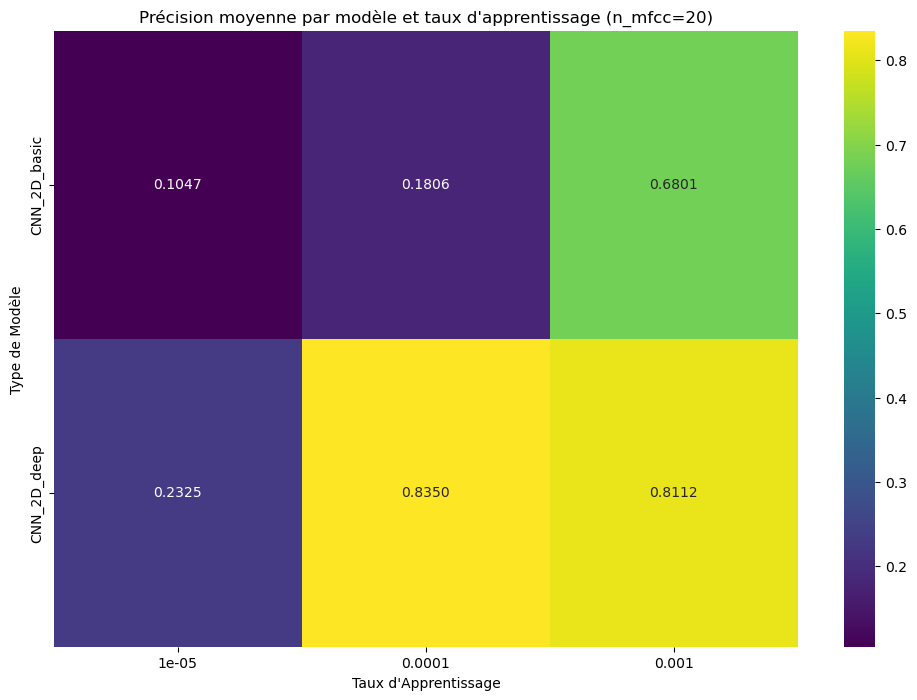

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x800 with 0 Axes>

In [41]:
# Heatmap de la précision en fonction du modèle et du taux d'apprentissage pour chaque n_mfcc
for n_mfcc in n_mfcc_values:
    plt.figure(figsize=(12, 8))
    subset = results_df[results_df['n_mfcc'] == n_mfcc]
    pivot_table = subset.pivot_table(values='accuracy', index='model_type', columns='learning_rate', aggfunc='mean')
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap='viridis')
    plt.title(f"Précision moyenne par modèle et taux d'apprentissage (n_mfcc={n_mfcc})")
    plt.ylabel("Type de Modèle")
    plt.xlabel("Taux d'Apprentissage")
    plt.show()


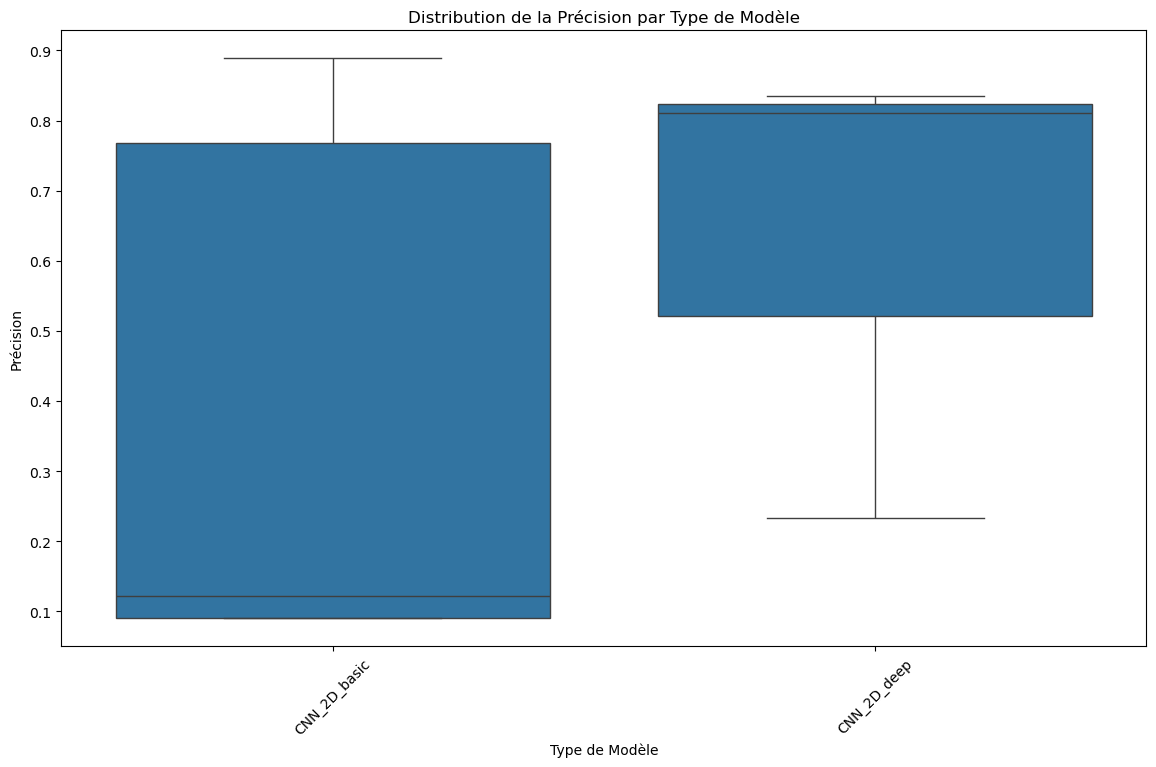

In [42]:
# Boxplot de la précision par type de modèle
plt.figure(figsize=(14, 8))
sns.boxplot(x='model_type', y='accuracy', data=results_df)
plt.title("Distribution de la Précision par Type de Modèle")
plt.xlabel("Type de Modèle")
plt.ylabel("Précision")
plt.xticks(rotation=45)
plt.show()


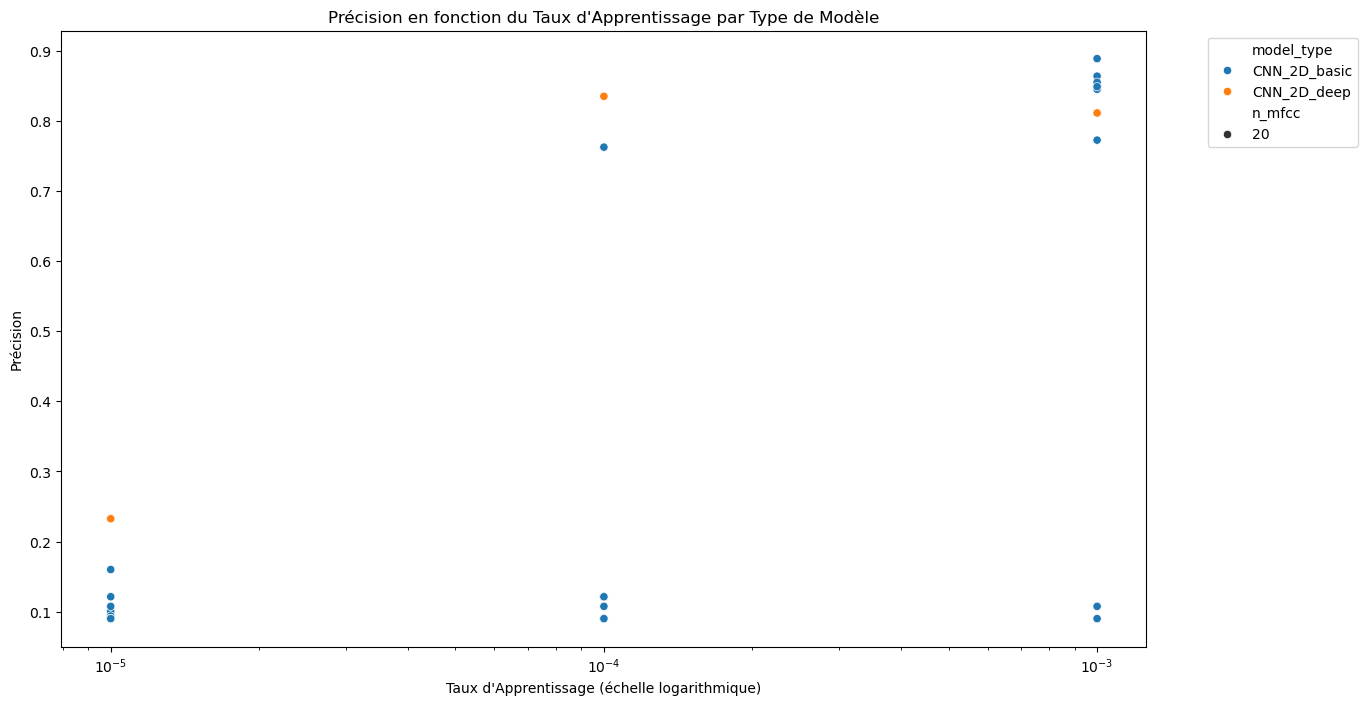

In [45]:
# Scatter plot de la précision en fonction du taux d'apprentissage pour chaque modèle
plt.figure(figsize=(14, 8))
sns.scatterplot(x='learning_rate', y='accuracy', hue='model_type', style='n_mfcc', data=results_df)
plt.xscale('log')
plt.title("Précision en fonction du Taux d'Apprentissage par Type de Modèle")
plt.xlabel("Taux d'Apprentissage (échelle logarithmique)")
plt.ylabel("Précision")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


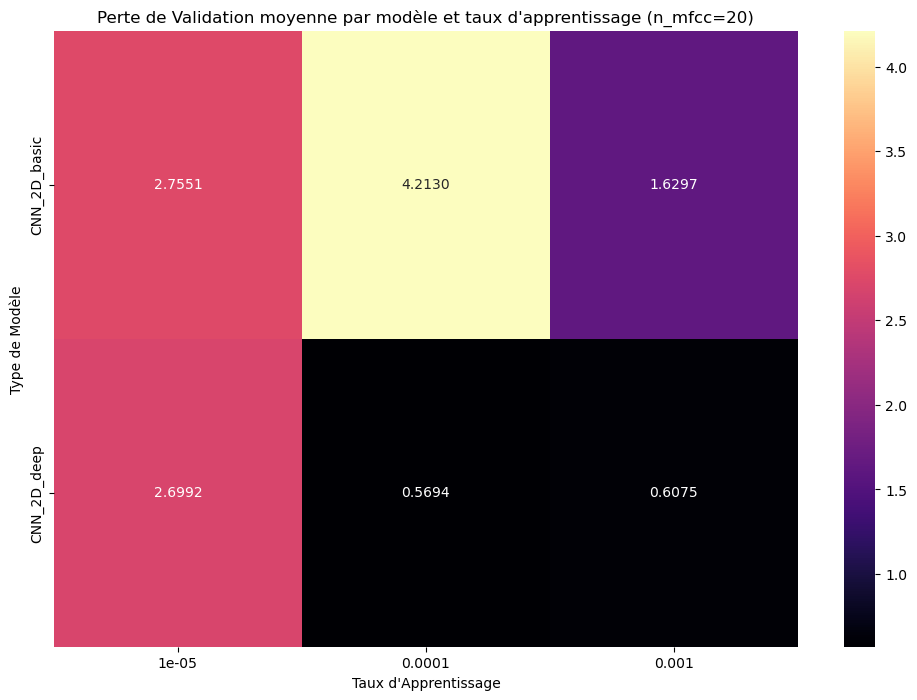

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x800 with 0 Axes>

In [47]:
# Heatmap de la perte de validation par modèle et taux d'apprentissage pour chaque n_mfcc
for n_mfcc in n_mfcc_values:
    plt.figure(figsize=(12, 8))
    subset = results_df[results_df['n_mfcc'] == n_mfcc]
    pivot_table = subset.pivot_table(values='validation_loss', index='model_type', columns='learning_rate', aggfunc='mean')
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap='magma')
    plt.title(f"Perte de Validation moyenne par modèle et taux d'apprentissage (n_mfcc={n_mfcc})")
    plt.ylabel("Type de Modèle")
    plt.xlabel("Taux d'Apprentissage")
    plt.show()

**Explications :**

- **Heatmap de la Précision** : Compare la précision moyenne pour chaque type de modèle et taux d'apprentissage, segmenté par `n_mfcc`.
- **Boxplot de la Précision** : Montre la distribution de la précision pour chaque type de modèle, permettant d'identifier la variabilité et les performances médianes.
- **Scatter Plot de la Précision** : Visualise la relation entre le taux d'apprentissage et la précision, avec une distinction par type de modèle et `n_mfcc`.
- **Boxplot du Score F1** : Permet de visualiser la distribution du score F1, une métrique équilibrée entre précision et rappel.
- **Heatmap de la Perte de Validation** : Compare la perte de validation moyenne pour chaque type de modèle et taux d'apprentissage, segmenté par `n_mfcc`.

## Étape 10 : Évaluation Approfondie

Pour une évaluation plus complète, calculons des métriques supplémentaires telles que le rapport de classification (classification report) et les courbes ROC (si applicable).

### 10.1. Rapport de Classification

Le rapport de classification fournit la précision, le rappel et le score F1 pour chaque classe.

In [48]:
# Sélectionner le meilleur modèle basé sur la précision
best_result = results_df.sort_values(by='accuracy', ascending=False).iloc[0]
best_model_path = f"models/n_mfcc_{best_result['n_mfcc']}/{best_result['model_type']}_bs{best_result['batch_size']}_ep{best_result['epochs']}_lr{best_result['learning_rate']}.keras"
best_model = load_model(best_model_path)
print(f"\nChargement du meilleur modèle : {best_model_path}")

# Re-évaluer pour obtenir le rapport de classification
y_pred = np.argmax(best_model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

print("\nRapport de Classification pour le Meilleur Modèle :")
print(classification_report(y_true, y_pred, target_names=encoder.classes_, zero_division=0))



Chargement du meilleur modèle : models/n_mfcc_20/CNN_2D_basic_bs32_ep100_lr0.001.keras


2024-12-09 23:53:24.537976: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

Rapport de Classification pour le Meilleur Modèle :
              precision    recall  f1-score   support

       blues       0.86      0.91      0.88        78
   classical       1.00      0.91      0.95        81
     country       0.91      0.76      0.83        84
       disco       0.91      0.81      0.86        86
      hiphop       0.94      0.93      0.94        70
        jazz       0.91      0.95      0.93        75
       metal       0.89      0.99      0.93        72
         pop       0.94      0.91      0.92        97
      reggae       0.88      0.88      0.88        82
        rock       0.72      0.89      0.80        75

    accuracy                           0.89       800
   macro avg       0.90      0.89      0.89       800
weighted avg       0.90      0.89      0.89       800



### 10.2. Courbes ROC et AUC

Pour chaque classe, nous pouvons tracer les courbes ROC et calculer l'AUC. Cependant, cela nécessite des prédictions en probabilités et une binarisation des labels.

**Note** : Les courbes ROC sont plus pertinentes pour des problèmes de classification binaire. Pour des classes multiples, nous utilisons une approche "un contre tous".

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


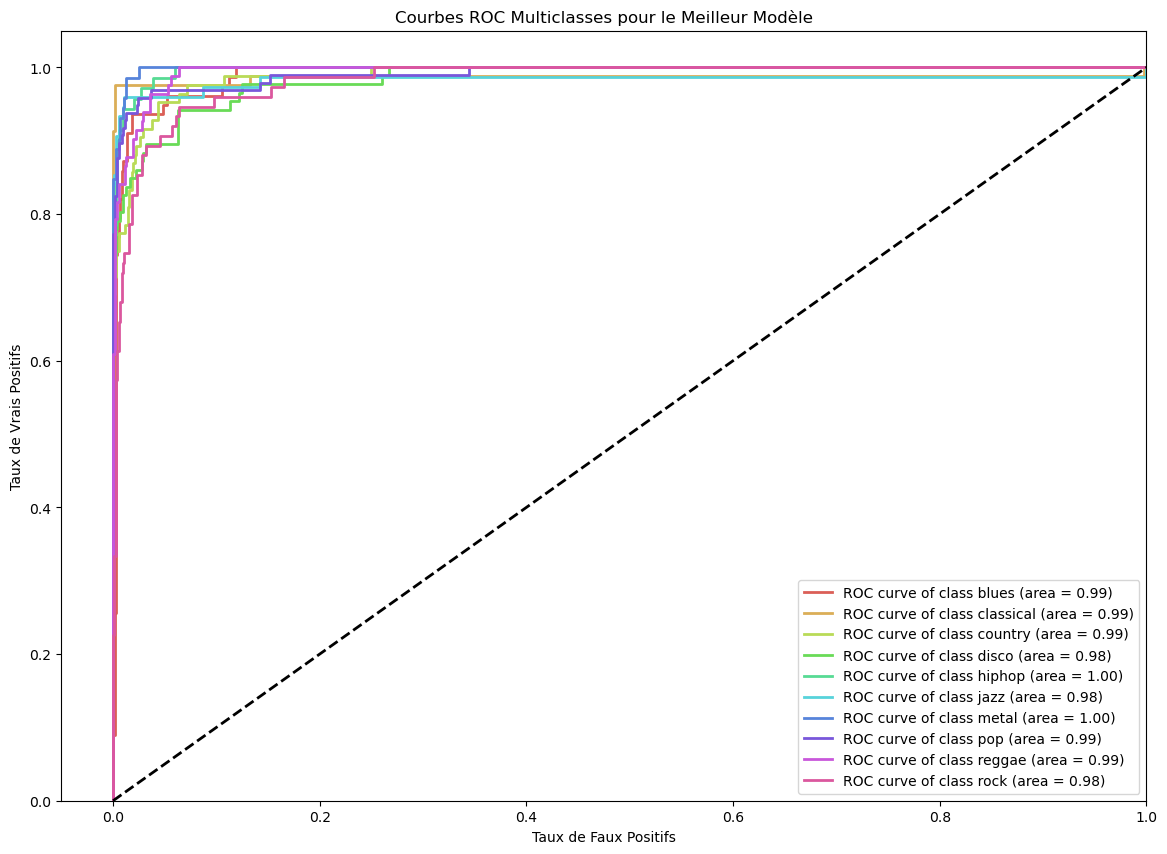

In [49]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binariser les labels
y_true_binarized = label_binarize(y_true, classes=np.arange(len(encoder.classes_)))
y_pred_proba = best_model.predict(X_test)

# Calculer les courbes ROC et AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer toutes les courbes ROC
plt.figure(figsize=(14, 10))
colors = sns.color_palette("hls", n_classes)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC Multiclasses pour le Meilleur Modèle')
plt.legend(loc="lower right")
plt.show()


**Explications :**

- **Rapport de Classification** : Fournit une vue détaillée des performances du modèle par classe, y compris la précision, le rappel et le score F1.
- **Courbes ROC et AUC** : Mesurent la capacité du modèle à distinguer chaque classe par rapport aux autres. L'AUC (Area Under the Curve) est une mesure globale de performance pour chaque classe.

### 10.3. Matrice de Confusion

Bien que vous ayez déjà une matrice de confusion, vous pouvez la refaire pour le meilleur modèle avec une visualisation améliorée.

<Figure size 1200x1000 with 0 Axes>

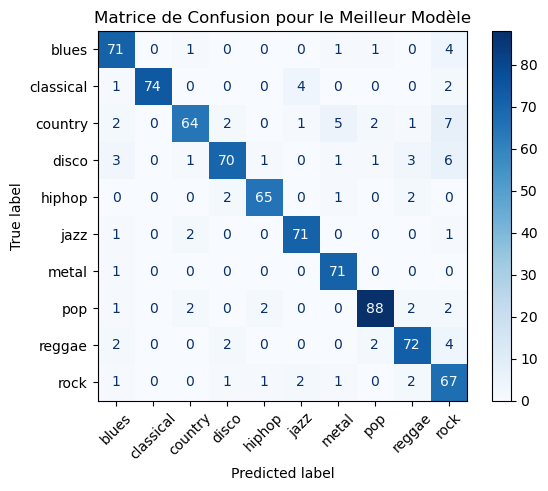

In [50]:
# Matrice de Confusion pour le Meilleur Modèle
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
ConfusionMatrixDisplay(conf_matrix, display_labels=encoder.classes_).plot(cmap='Blues', xticks_rotation=45)
plt.title("Matrice de Confusion pour le Meilleur Modèle")
plt.show()

## Étape 11 : Sauvegarder et Charger les Meilleurs Modèles

Pour réutiliser les meilleurs modèles sans avoir à les réentraîner, nous pouvons les sauvegarder et les charger ultérieurement.

### 11.1. Sauvegarde des Meilleurs Modèles

Les modèles sont déjà sauvegardés pendant l'entraînement grâce au callback `ModelCheckpoint`. Assurez-vous que les chemins des modèles sont correctement définis dans les résultats.

### 11.2. Chargement d'un Modèle Sauvegardé

Voici comment charger un modèle sauvegardé et l'utiliser pour faire des prédictions.

In [51]:
# Exemple de chargement d'un modèle sauvegardé
best_result = results_df.sort_values(by='accuracy', ascending=False).iloc[0]
best_model_path = f"models/n_mfcc_{best_result['n_mfcc']}/{best_result['model_type']}_bs{best_result['batch_size']}_ep{best_result['epochs']}_lr{best_result['learning_rate']}.keras"
best_model = load_model(best_model_path)
print(f"\nChargement du meilleur modèle : {best_model_path}")

# Charger l'encodeur des labels (si non déjà chargé)
encoder = joblib.load('label_encoder.joblib')


Chargement du meilleur modèle : models/n_mfcc_20/CNN_2D_basic_bs32_ep100_lr0.001.keras


### 11.3. Fonction de Prédiction

Voici une fonction de prédiction réutilisable avec le modèle chargé.

In [52]:
def predict_genre(file_path, model, encoder, fixed_length=1293, n_mfcc=40):
    """
    Prédit le genre musical d'un fichier audio.
    """
    try:
        audio, sr = librosa.load(file_path, duration=30)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfccs = pad_or_truncate_mfcc(mfccs, fixed_length)
        mfccs = mfccs[..., np.newaxis]  # Ajouter la dimension canal
        mfccs = np.expand_dims(mfccs, axis=0)  # Ajouter la dimension batch

        # Normalisation
        mfccs = mfccs / np.max(mfccs)

        # Prédiction
        y_pred_proba = model.predict(mfccs)
        predicted_genre_index = np.argmax(y_pred_proba, axis=-1)
        predicted_genre = encoder.inverse_transform(predicted_genre_index)[0]
        return predicted_genre, y_pred_proba
    except Exception as e:
        print(f"Erreur lors de la prédiction : {e}")
        return None, None


## Étape 12 : Prédiction sur de Nouveaux Échantillons

Téléchargeons un nouvel échantillon audio depuis YouTube et effectuons une prédiction en utilisant le meilleur modèle.

In [53]:
# Télécharger un fichier audio depuis YouTube
youtube_url = "https://youtu.be/tAGnKpE4NCI?si=6me8uc6lZW-LZLrA" 
download_youtube_audio(youtube_url, "test_audio.wav")

# Faire une prédiction
predicted_genre, y_pred_proba = predict_genre("test_audio.wav", best_model, encoder, fixed_length=best_result['n_mfcc'], n_mfcc=best_result['n_mfcc'])
print(f"Le genre prédit pour 'test_audio.wav' est : {predicted_genre}")

[youtube] Extracting URL: https://youtu.be/tAGnKpE4NCI?si=6me8uc6lZW-LZLrA
[youtube] tAGnKpE4NCI: Downloading webpage
[youtube] tAGnKpE4NCI: Downloading ios player API JSON
[youtube] tAGnKpE4NCI: Downloading mweb player API JSON
[youtube] tAGnKpE4NCI: Downloading player 3bb1f723


[youtube] tAGnKpE4NCI: Downloading m3u8 information
[info] tAGnKpE4NCI: Downloading 1 format(s): 251
[download] Destination: temp_audio.webm
[download] 100% of    6.33MiB in 00:00:00 at 27.04MiB/s  
[ExtractAudio] Destination: temp_audio.wav
Deleting original file temp_audio.webm (pass -k to keep)
Audio téléchargé et sauvegardé sous : test_audio.wav
Erreur lors de la prédiction : Exception encountered when calling Sequential.call().

Input 0 of layer "dense_54" is incompatible with the layer: expected axis -1 of input shape to have value 41216, but received input with shape (1, 512)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 20, 20, 1), dtype=float32)
  • training=False
  • mask=None
Le genre prédit pour 'test_audio.wav' est : None


/var/folders/g9/jzqz957j1slb_dkhyp9fl5_w0000gn/T/ipykernel_35556/1720711677.py:13: RuntimeWarning: divide by zero encountered in divide
  mfccs = mfccs / np.max(mfccs)
/var/folders/g9/jzqz957j1slb_dkhyp9fl5_w0000gn/T/ipykernel_35556/1720711677.py:13: RuntimeWarning: invalid value encountered in divide
  mfccs = mfccs / np.max(mfccs)


### 12.1. Afficher les Probabilités de Prédiction

Vous pouvez également afficher les probabilités associées à chaque classe.

In [54]:
if y_pred_proba is not None:
    probabilities = y_pred_proba.flatten()
    genre_probabilities = dict(zip(encoder.classes_, probabilities))
    sorted_genres = sorted(genre_probabilities.items(), key=lambda x: x[1], reverse=True)

    print("\nProbabilités de prédiction par genre :")
    for genre, prob in sorted_genres:
        print(f"{genre}: {prob * 100:.2f}%")

    # Bar plot des probabilités
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(genre_probabilities.keys()), y=list(genre_probabilities.values()))
    plt.title("Probabilités de Prédiction par Genre")
    plt.xlabel("Genre")
    plt.ylabel("Probabilité")
    plt.xticks(rotation=45)
    plt.show()


## Conclusion

En suivant ce notebook structuré en blocs, vous pouvez systématiquement tester différentes combinaisons de modèles et d'hyperparamètres pour optimiser la classification des genres musicaux. Voici quelques points clés à retenir :

- **Organisation en Blocs** : Chaque étape du processus est clairement séparée, ce qui facilite la maintenance et l'expérimentation.
- **Automatisation des Tests** : L'utilisation de boucles imbriquées permet de tester efficacement toutes les combinaisons d'hyperparamètres.
- **Métriques Complètes** : En plus de la précision, le rappel et le score F1 fournissent une vue plus équilibrée des performances du modèle, surtout en cas de déséquilibre des classes.
- **Visualisation des Résultats** : Les graphiques générés permettent une analyse visuelle rapide des performances des différents modèles et hyperparamètres.
- **Sauvegarde des Modèles** : Grâce à `ModelCheckpoint`, les meilleurs modèles sont automatiquement sauvegardés, ce qui évite de perdre les performances optimales obtenues.
- **Réutilisation des Modèles** : Les modèles sauvegardés peuvent être facilement chargés pour des prédictions futures sans nécessiter un nouvel entraînement.